## Parameter estimation with NN search in database

# DETACHED SYSTEMS

The purpose of this "adventure" is to test how well the parameters of a set of binary systems can be estimated in bulk with nearest neighbors search in a larger database. The database and test set are computed using phoebe2 and there are ~100,000 database LCs and ~100 test LCs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl

Let's load the database light curves and their coressponding parameter values as well as the test light curves and the parameters used to generate them that we'll try to estimate from the database.

In [2]:
db_database = np.loadtxt('detached/db_database.dat')
db_database_params = np.loadtxt('detached/db_database_params.dat')
db_test = np.loadtxt('detached/db_test.dat')
db_test_params = np.loadtxt('detached/db_test_params.dat')

The parameters used to generate the lcs and the ones we'll try to estimate are:

In [3]:
db_param_names = ['q', 'r1', 'r2', 'tratio', 'incl', 'ecc', 'per0']

For this to work, the flux values of all of the database and test LCs need to be roughly the same because otherwise the flux is the primary similarity factor and makes it hard to estimate the rest. So let's check that this holds for our lcs by plotting a subset.

In [4]:
ii = np.random.uniform(0,len(db_database), 100).astype(int)

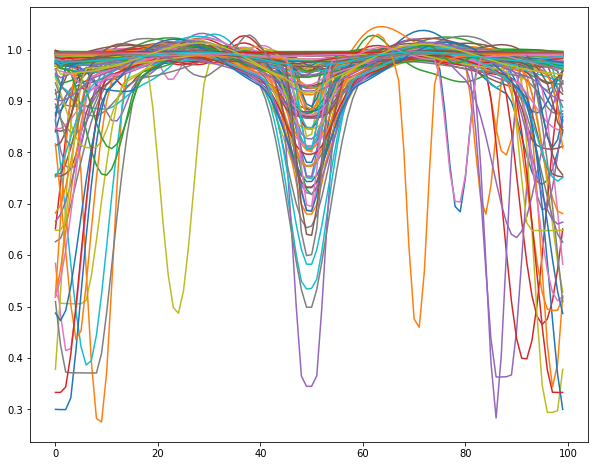

In [5]:
plt.figure(figsize=(10,8))
for i in ii:
    plt.plot(db_database[i])

### nearest-neighbors interpolation

Parameter estimation using nearest neighbors utilizes the Nearest Neighbors method of sklearn and some added magic to compute the parameter values. The "magic" the Eucledean distances of the nearest neighbors from our test lc to compute weights used to estimate the parameters of interest as a linear combination of the parameter values of the nearest neighbors in the database.

In [6]:
from sklearn.neighbors import NearestNeighbors as NN

def interp_nearest(lc_test, lc_db, nn=50):
    nbrs = NN(n_neighbors=nn).fit(lc_db)
    ds_0, inds_0 = nbrs.kneighbors(lc_test)
    ws = (1./ds_0)**2
    fs=(1./np.sum(ws,axis=1))
    weights=ws*fs[:,np.newaxis]
    return ds_0, inds_0, weights

The following line returns the distances, database indices of the NNs and their corresponding weights:

In [7]:
db_ds, db_inds, db_ws = interp_nearest(db_test, db_database, nn=10)

Now we can compute the estimated parameter values and their ranges using the parameter values of the nn neighbors of each test lc.

In [8]:
db_params_interp = np.array([np.sum(db_database_params[:,i][db_inds]*db_ws,axis=1) for i in range(0, len(db_database_params[0]))]).T
db_params_min = np.array([np.min(db_database_params[:,i][db_inds],axis=1) for i in range(0, len(db_database_params[0]))]).T
db_params_max = np.array([np.max(db_database_params[:,i][db_inds],axis=1) for i in range(0, len(db_database_params[0]))]).T

To see how close we are to the true parameter values, let's make some plots. The x-axis different test lcs, while on the y axis are the values of different parameters. Black crosses mark the true values, red dots the database-estimated ones, while green and blue dots correspond to the minimum and maximum value found in the nns, respectively.

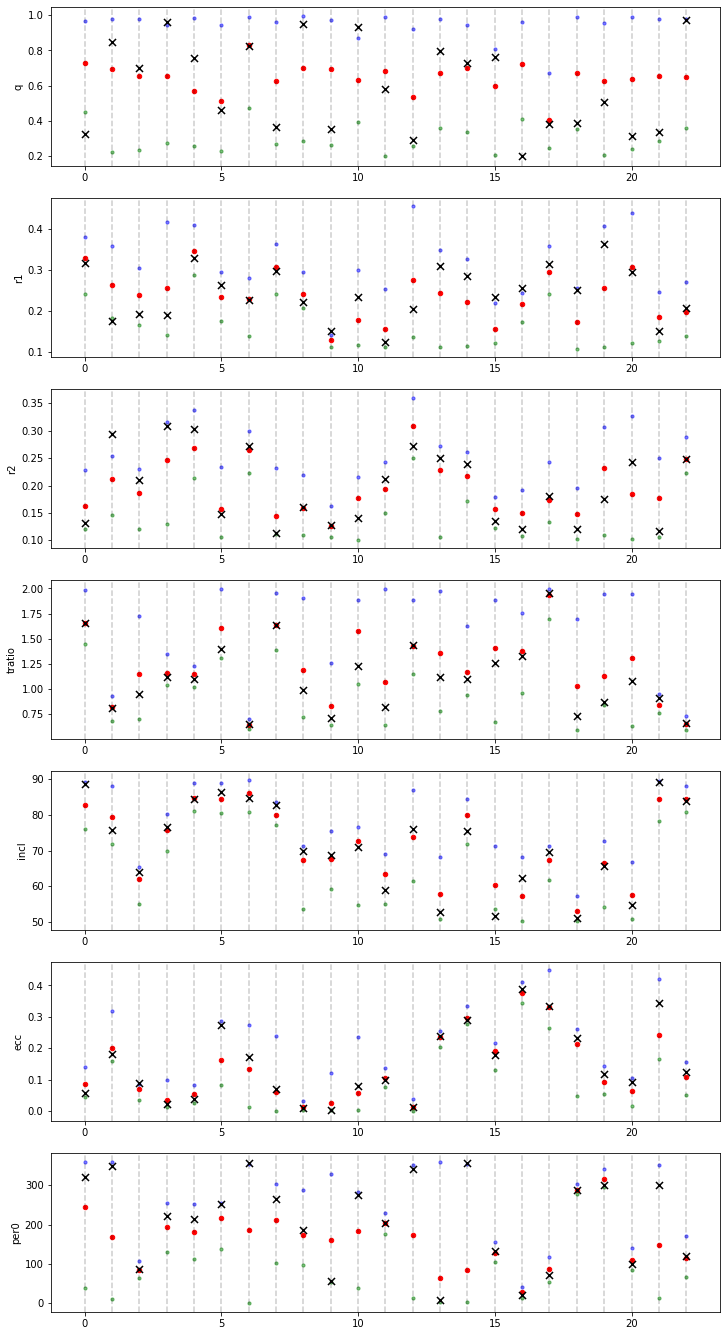

In [9]:
skip=3
length = len(db_params_interp[:,0][::skip])
fig, axes = plt.subplots(len(db_database_params[0]), figsize=(12,24))
for i in range(len(axes)):
    axes[i].scatter(range(length), db_params_interp[:,i][::skip], marker='o', c='r', s=20)
    axes[i].scatter(range(length), db_params_min[:,i][::skip], marker='o', c='g', s=10, alpha=0.5)
    axes[i].scatter(range(length), db_params_max[:,i][::skip], marker='o', c='b', s=10, alpha=0.5)
    axes[i].scatter(range(length), db_test_params[:,i][::skip], marker='x', c='k', s=50)
    for j in range(length):
        axes[i].axvline(x=j, c='k', linestyle='--', alpha=0.2)
    axes[i].set_ylabel(db_param_names[i])

### database visualization with t-SNE

As we can see, some parameters, like eccentricity, inclination, temperature ratio or fractional radii, are reasonably well-estimated and within narrow ranges of nn values. But others, like mass ratio, are not. To further explore why that happens, let's try to visualize the database in terms of light curve similarities with t-SNE. Coloring the t-SNE maps by the different parameter values will give us an idea of which parameters drive the lc similarities and most, and hence which ones our NN search will be most sensitive to.

In [10]:
skip_tsne = 10
from sklearn.manifold import TSNE
map_tsne = TSNE(n_components=3, perplexity=30).fit_transform(db_database[::skip_tsne])

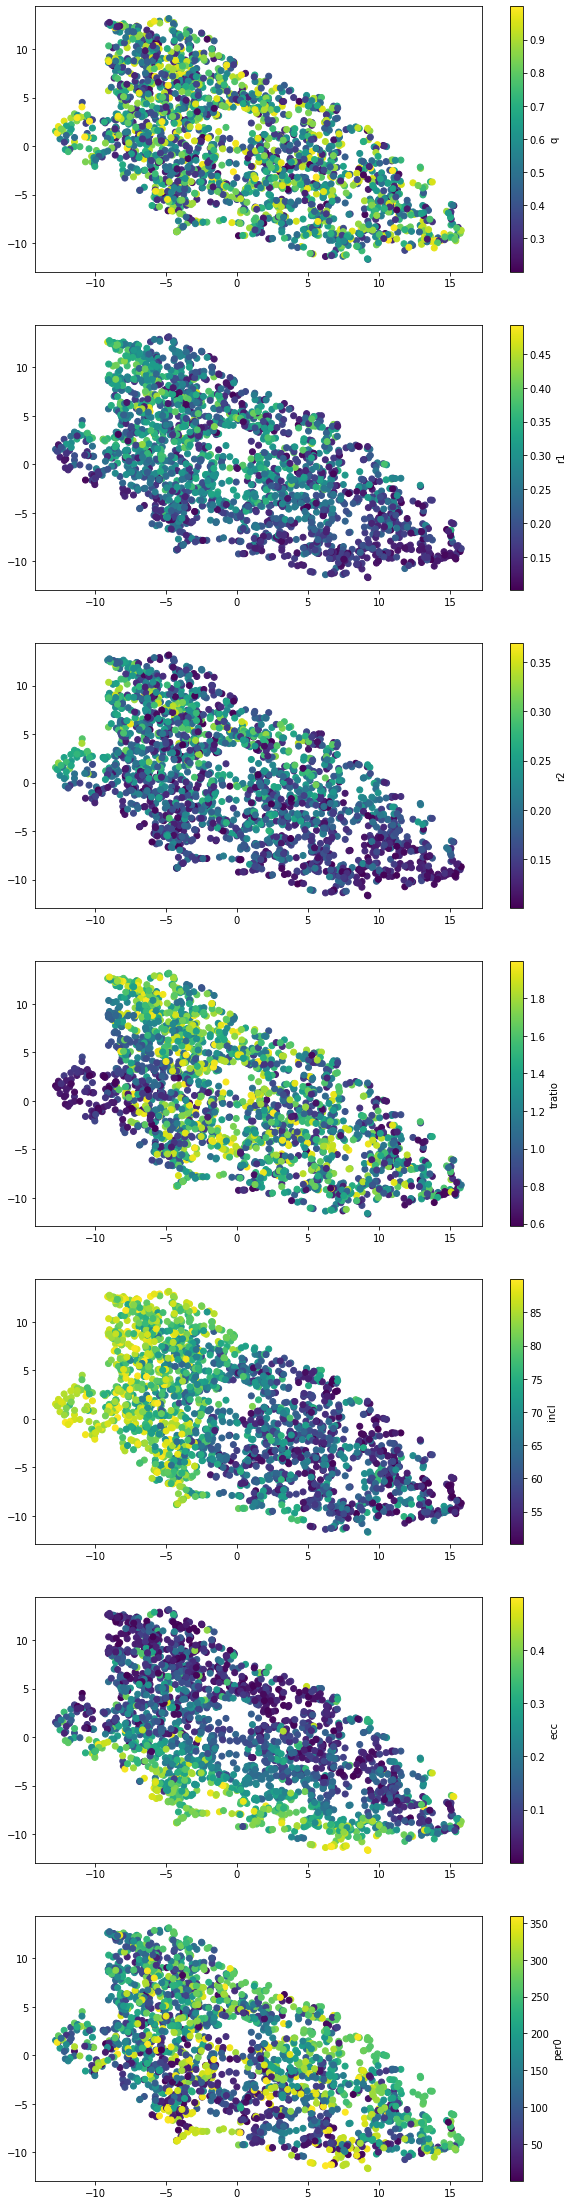

In [11]:
fig, axes = plt.subplots(len(db_database_params[0]), figsize=(10,40))
x = 1
y = 2
for i in range(len(axes)):
    cb = axes[i].scatter(map_tsne[:,x], map_tsne[:,y], c=db_database_params[:,i][::skip_tsne])
    fig.colorbar(cb, ax = axes[i], label=db_param_names[i])

Next, we'll apply the method outlined above for a database and test set of semi-detached and contact binaries.

# SEMI-DETACHED SYSTEMS

In [12]:
sdb_database = np.loadtxt('semi-detached/sdb_database.dat')
sdb_database_params = np.loadtxt('semi-detached/sdb_database_params.dat')
sdb_test = np.loadtxt('semi-detached/sdb_test.dat')
sdb_test_params = np.loadtxt('semi-detached/sdb_test_params.dat')

In [13]:
sdb_param_names = ['q', 'r2', 'tratio', 'incl', 'ecc', 'per0']

### nearest-neighbors interpolation

In [14]:
sdb_ds, sdb_inds, sdb_ws = interp_nearest(sdb_test, sdb_database, nn=10)

In [15]:
sdb_params_interp = np.array([np.sum(sdb_database_params[:,i][sdb_inds]*sdb_ws,axis=1) for i in range(0, len(sdb_database_params[0]))]).T
sdb_params_min = np.array([np.min(sdb_database_params[:,i][sdb_inds],axis=1) for i in range(0, len(sdb_database_params[0]))]).T
sdb_params_max = np.array([np.max(sdb_database_params[:,i][sdb_inds],axis=1) for i in range(0, len(sdb_database_params[0]))]).T

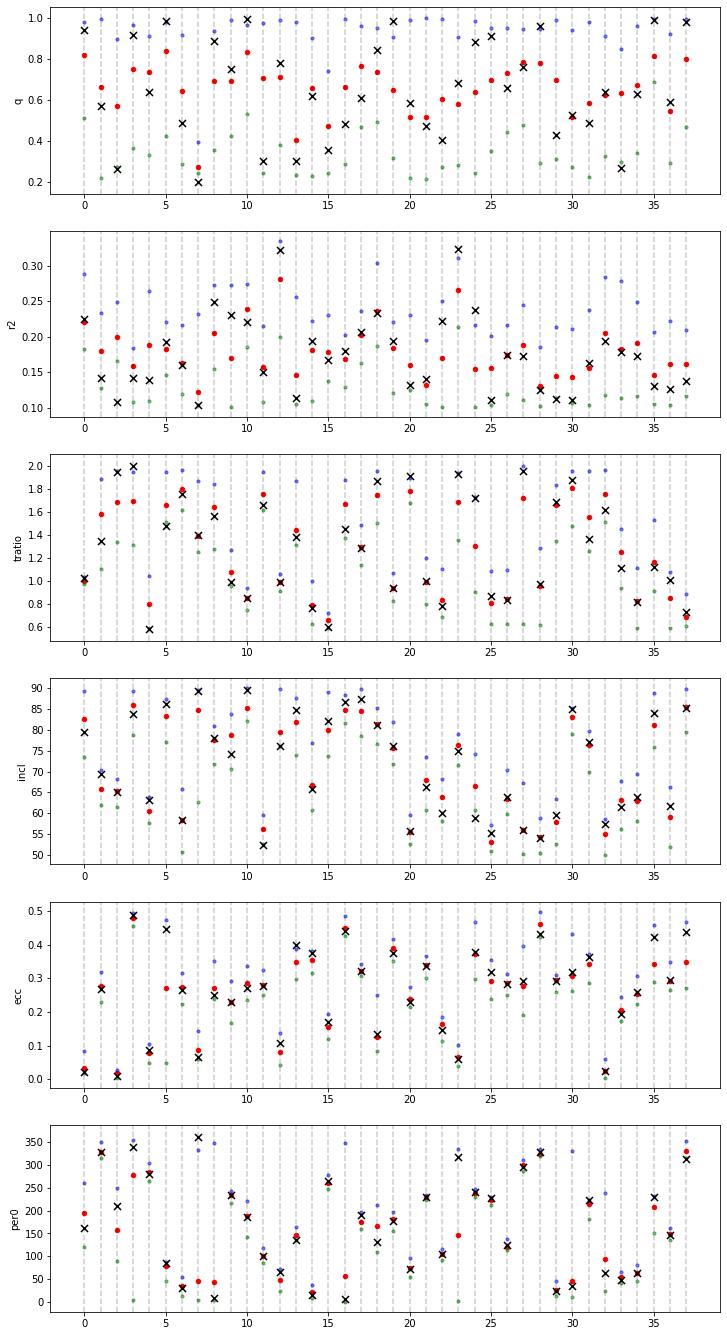

In [16]:
skip=3
length = len(sdb_params_interp[:,0][::skip])
fig, axes = plt.subplots(len(sdb_database_params[0]), figsize=(12,24))
for i in range(len(axes)):
    axes[i].scatter(range(length), sdb_params_interp[:,i][::skip], marker='o', c='r', s=20)
    axes[i].scatter(range(length), sdb_params_min[:,i][::skip], marker='o', c='g', s=10, alpha=0.5)
    axes[i].scatter(range(length), sdb_params_max[:,i][::skip], marker='o', c='b', s=10, alpha=0.5)
    axes[i].scatter(range(length), sdb_test_params[:,i][::skip], marker='x', c='k', s=50)
    for j in range(length):
        axes[i].axvline(x=j, c='k', linestyle='--', alpha=0.2)
    axes[i].set_ylabel(sdb_param_names[i])

### database visualization with t-SNE

In [17]:
skip_tsne = 20
from sklearn.manifold import TSNE
map_tsne = TSNE(n_components=3, perplexity=30).fit_transform(sdb_database[::skip_tsne])

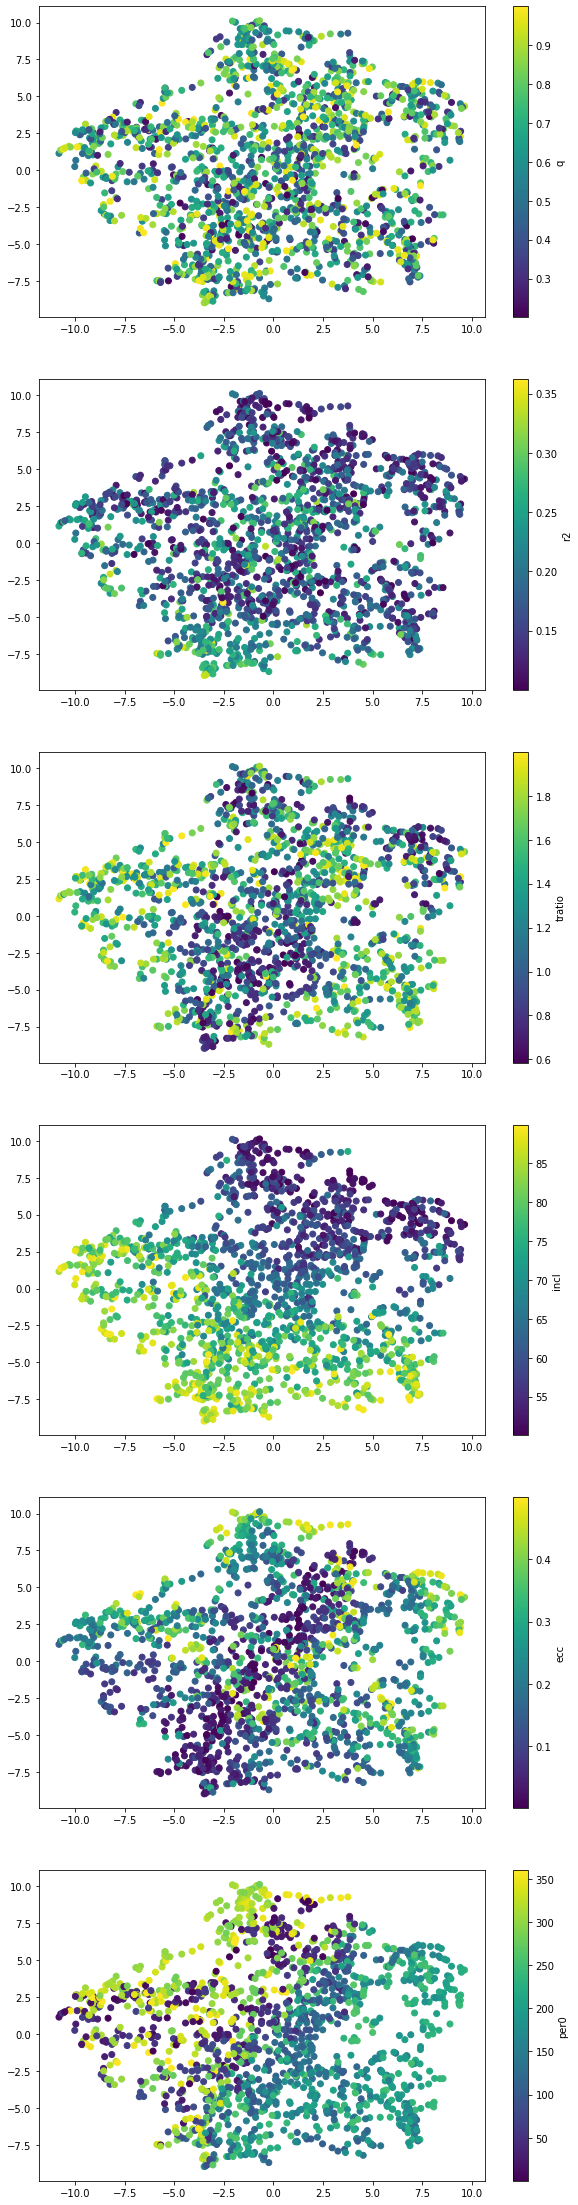

In [18]:
fig, axes = plt.subplots(len(sdb_database_params[0]), figsize=(10,40))
x = 0
y = 1
cbs = []
for i in range(len(axes)):
    cb = axes[i].scatter(map_tsne[:,x], map_tsne[:,y], c=sdb_database_params[:,i][::skip_tsne])
    fig.colorbar(cb, ax = axes[i], label=sdb_param_names[i])

# CONTACT SYSTEMS

In [19]:
cb_database = np.loadtxt('contact/cb_database.dat')
cb_database_params = np.loadtxt('contact/cb_database_params.dat')
cb_test = np.loadtxt('contact/cb_test.dat')
cb_test_params = np.loadtxt('contact/cb_test_params.dat')

In [20]:
cb_param_names = ['incl', 'tratio', 'ff', 'q']

### nearest-neighbors interpolation

In [21]:
cb_ds, cb_inds, cb_ws = interp_nearest(cb_test, cb_database, nn=10)

In [22]:
cb_params_interp = np.array([np.sum(cb_database_params[:,i][cb_inds]*cb_ws,axis=1) for i in range(0, len(cb_database_params[0]))]).T
cb_params_min = np.array([np.min(cb_database_params[:,i][cb_inds],axis=1) for i in range(0, len(cb_database_params[0]))]).T
cb_params_max = np.array([np.max(cb_database_params[:,i][cb_inds],axis=1) for i in range(0, len(cb_database_params[0]))]).T

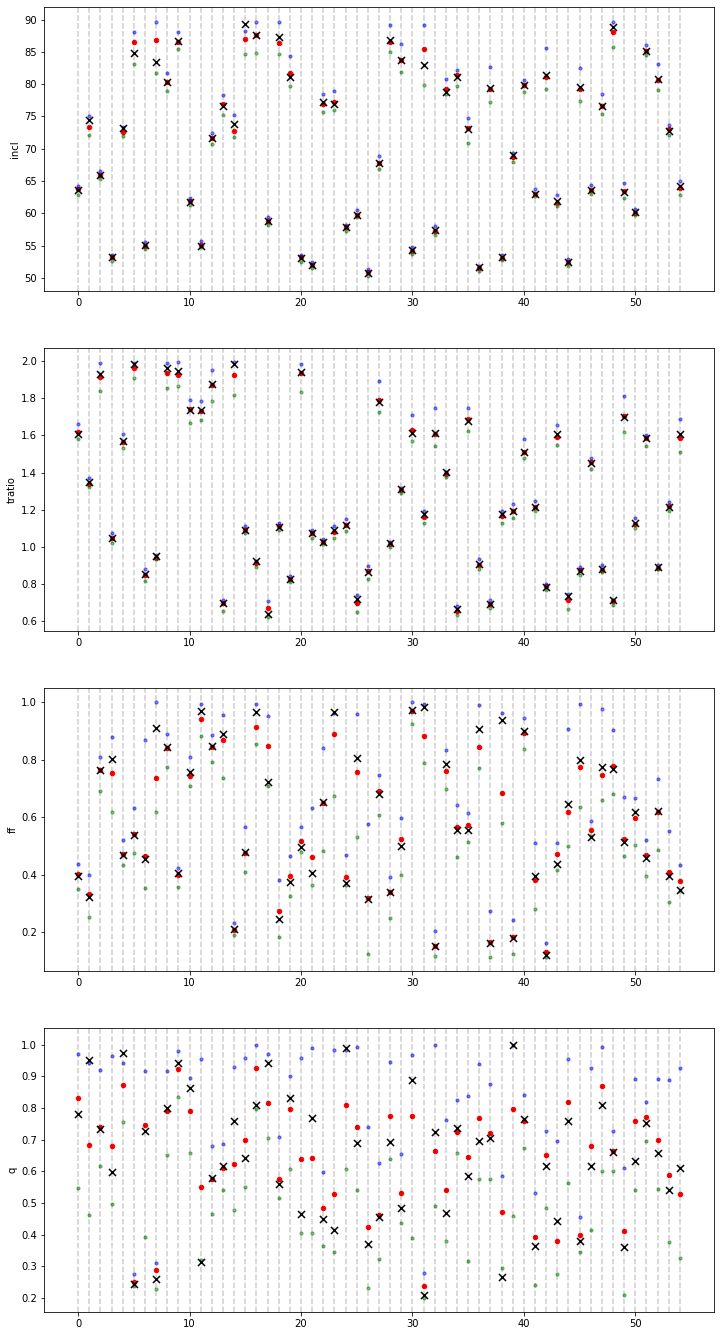

In [23]:
skip=5
length = len(cb_params_interp[:,0][::skip])
fig, axes = plt.subplots(len(cb_database_params[0]), figsize=(12,24))
for i in range(len(axes)):
    axes[i].scatter(range(length), cb_params_interp[:,i][::skip], marker='o', c='r', s=20)
    axes[i].scatter(range(length), cb_params_min[:,i][::skip], marker='o', c='g', s=10, alpha=0.5)
    axes[i].scatter(range(length), cb_params_max[:,i][::skip], marker='o', c='b', s=10, alpha=0.5)
    axes[i].scatter(range(length), cb_test_params[:,i][::skip], marker='x', c='k', s=50)
    for j in range(length):
        axes[i].axvline(x=j, c='k', linestyle='--', alpha=0.2)
    axes[i].set_ylabel(cb_param_names[i])

### database visualization with t-SNE

In [24]:
skip_tsne = 50
from sklearn.manifold import TSNE
map_tsne = TSNE(n_components=3, perplexity=30).fit_transform(cb_database[::skip_tsne])

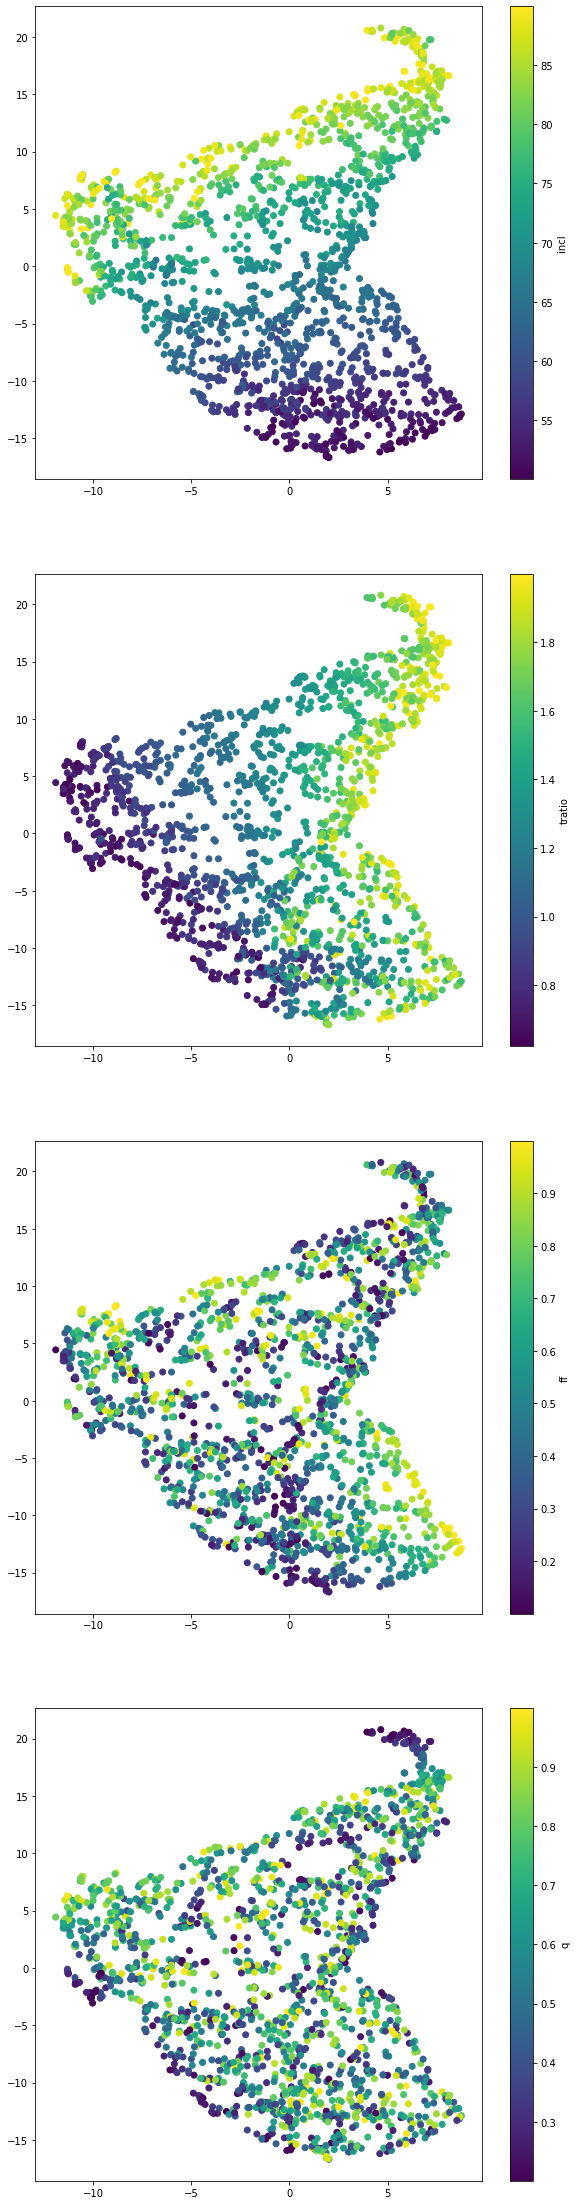

In [25]:
fig, axes = plt.subplots(len(cb_database_params[0]), figsize=(10,40))
x = 0
y = 1
cbs = []
for i in range(len(axes)):
    cb = axes[i].scatter(map_tsne[:,x], map_tsne[:,y], c=cb_database_params[:,i][::skip_tsne])
    fig.colorbar(cb, ax = axes[i], label=cb_param_names[i])